In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [2]:
movies_list = pd.read_csv('ml-latest-small/movies.csv')
movies_list.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
ratings = ratings.merge(movies_list, on='movieId').drop(['genres','timestamp'],axis=1)
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [5]:
user_enc = LabelEncoder()
ratings['userSeq'] = user_enc.fit_transform(ratings['userId'].values)

item_enc = LabelEncoder()
ratings['movieSeq'] = item_enc.fit_transform(ratings['movieId'].values)

ratings.head()

,userId,movieId,rating,title,userSeq,movieSeq
0,1,1,4.0,Toy Story (1995),0,0
1,5,1,4.0,Toy Story (1995),4,0
2,7,1,4.5,Toy Story (1995),6,0
3,15,1,2.5,Toy Story (1995),14,0
4,17,1,4.5,Toy Story (1995),16,0


In [6]:
train_unused, test = train_test_split(ratings, test_size=0.20, random_state=0)

train = ratings

numUsers = len(train.userSeq.unique())
numMovies = len(train.movieSeq.unique())
print((numUsers, numMovies))
print((len(train), len(test)))

(610, 9724)
(100836, 20168)


In [7]:
numFeatures = 50
dropout = 0.0

user_input = Input(shape=(1,))
user_emb = Embedding(numUsers, numFeatures)(user_input)
flat_user = Flatten()(user_emb)
user_dropout = Dropout(dropout)(flat_user)

movie_input = Input(shape=(1,))
movie_emb = Embedding(numMovies, numFeatures)(movie_input)
flat_movie = Flatten()(movie_emb)
movie_dropout = Dropout(dropout)(flat_movie)

dotProduct = Dot(axes=1)([user_dropout, movie_dropout])

user_bias = Embedding(numUsers, 1)(user_input)
movie_bias = Embedding(numMovies, 1)(movie_input)
sum = Add()([dotProduct, user_bias, movie_bias])
flat_sum = Flatten()(sum)
output = Dropout(dropout)(flat_sum)

model = Model([user_input, movie_input], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
______________________________________________________________________________________________

In [8]:
model.compile(loss='mean_squared_error', optimizer=Adam())
history = model.fit([train.userSeq, train.movieSeq], train.rating,
                    batch_size=32, epochs=10, verbose=1,
                    validation_data=([test.userSeq, test.movieSeq], test.rating))


Train on 100836 samples, validate on 20168 samples
Epoch 1/10
100836/100836 [==============================] - 40s 393us/sample - loss: 6.1357 - val_loss: 1.4337
Epoch 2/10
100836/100836 [==============================] - 36s 357us/sample - loss: 1.1543 - val_loss: 0.8260
Epoch 3/10
100836/100836 [==============================] - 37s 366us/sample - loss: 0.8400 - val_loss: 0.6788
Epoch 4/10
100836/100836 [==============================] - 37s 366us/sample - loss: 0.7089 - val_loss: 0.5729
Epoch 5/10
100836/100836 [==============================] - 37s 365us/sample - loss: 0.5977 - val_loss: 0.4757
Epoch 6/10
100836/100836 [==============================] - 37s 366us/sample - loss: 0.4988 - val_loss: 0.3916
Epoch 7/10
100836/100836 [==============================] - 38s 373us/sample - loss: 0.4132 - val_loss: 0.3202
Epoch 8/10
100836/100836 [==============================] - 37s 372us/sample - loss: 0.3415 - val_loss: 0.2599
Epoch 9/10
100836/100836 [==============================] - 3

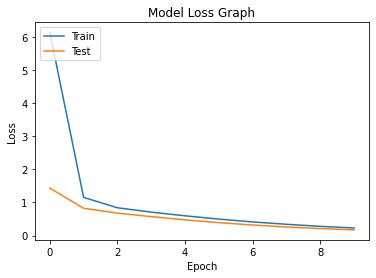

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
userNumber = 0    #Prediction for user with userId 1

uniqueMovies = ratings.drop_duplicates(subset=['movieSeq'])

movie_vector = uniqueMovies.movieSeq.values
user_vector = np.ones((len(uniqueMovies),)) * userNumber
predictions = model.predict([user_vector, movie_vector])
pSeries = pd.Series([a[0] for a in predictions])
predictedDF = uniqueMovies.copy()
predictedDF['Predictions'] = pSeries

predictedDF.sort_values(by='Predictions', ascending=False).head(10)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions
5770,1,1025,5.0,"Sword in the Stone, The (1963)",0,783,5.944517
4121,1,592,4.0,Batman (1989),0,509,5.703566
6127,1,1080,5.0,Monty Python's Life of Brian (1979),0,819,5.363903
1135,1,157,5.0,Canadian Bacon (1995),0,130,5.335959
6347,1,1090,4.0,Platoon (1986),0,828,5.327193
2316,1,349,4.0,Clear and Present Danger (1994),0,307,5.204981
3570,1,527,5.0,Schindler's List (1993),0,461,5.121490
4830,1,648,3.0,Mission: Impossible (1996),0,546,5.066984
5540,1,804,4.0,She's the One (1996),0,632,5.056573
1146,1,163,5.0,Desperado (1995),0,136,5.024573


In [12]:
userNumber = 9   #user with userId 10

uniqueMovies = ratings.drop_duplicates(subset=['movieSeq'])

movie_vector = uniqueMovies.movieSeq.values
user_vector = np.ones((len(uniqueMovies),)) * userNumber
predictions = model.predict([user_vector, movie_vector])
pSeries = pd.Series([a[0] for a in predictions])
predictedDF = uniqueMovies.copy()
predictedDF['Predictions'] = pSeries

predictedDF.sort_values(by='Predictions', ascending=False).head(15)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions
4121,1,592,4.0,Batman (1989),0,509,4.508100
5972,1,1060,4.0,Swingers (1996),0,810,3.960686
5770,1,1025,5.0,"Sword in the Stone, The (1963)",0,783,3.880115
4830,1,648,3.0,Mission: Impossible (1996),0,546,3.789411
0,1,1,4.0,Toy Story (1995),0,0,3.777242
4992,1,661,5.0,James and the Giant Peach (1996),0,551,3.551711
2755,1,362,5.0,"Jungle Book, The (1994)",0,320,3.545061
6347,1,1090,4.0,Platoon (1986),0,828,3.453760
2426,1,356,4.0,Forrest Gump (1994),0,314,3.446981
6127,1,1080,5.0,Monty Python's Life of Brian (1979),0,819,3.366037
